# Chapter 4 - Regression and Prediction

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.gofplots import ProbPlot

from pygam import LinearGAM, s, l
from pygam.datasets import wage

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter

from dmba import stepwise_selection
from dmba import AIC_score

# Simple Linear Regression

In [4]:
url1 = ('https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/refs/heads/master/data/LungDisease.csv')

lung = pd.read_csv(url1)

lung.head()

,PEFR,Exposure
0,390,0
1,410,0
2,430,0
3,460,0
4,420,1


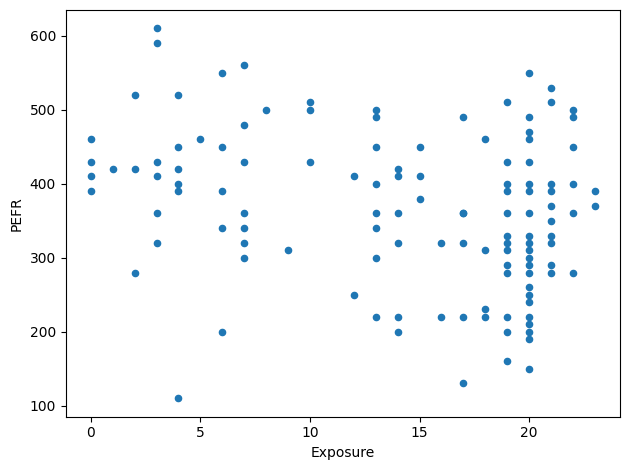

In [5]:
lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

In [6]:
predictors = ['Exposure']  # Define the predictors for the linear model, in this case, just 'Exposure'.
outcome = 'PEFR'           # Define the outcome or target variable, which is 'PEFR'.

model = LinearRegression()                  # Initialize the linear regression model
model.fit(lung[predictors], lung[outcome])  # Fit the model using the predictor and outcome variables from the lung dataset

print(f'Intercept: {model.intercept_:.3f}')           # Print the intercept of the linear model
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')  # Print the coefficient for 'Exposure'

Intercept: 424.583
Coefficient Exposure: -4.185


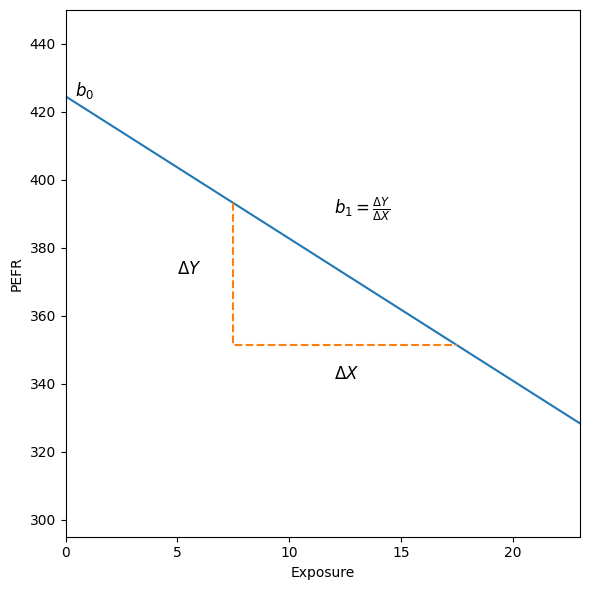

In [7]:
fig, ax = plt.subplots(figsize=(6, 6)) # Create a figure and axis with dimensions 6x6 inches
ax.set_xlim(0, 23)                     # Set the limit of the x-axis from 0 to 23
ax.set_ylim(295, 450)                  # Set the limit of the y-axis from 295 to 450
ax.set_xlabel('Exposure')              # Set the label for the x-axis as 'Exposure'
ax.set_ylabel('PEFR')                  # Set the label for the y-axis as 'PEFR'
ax.plot((0, 23), model.predict(pd.DataFrame({'Exposure': [0, 23]}))) # Plot the linear regression line based on predictions from Exposure values 0 to 23
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')              # Annotate the y-intercept (b_0) on the plot, placing the text near the intercept

x = pd.DataFrame({'Exposure': [7.5, 17.5]})           # Create a DataFrame for two exposure values, 7.5 and 17.5
y = model.predict(x)                                  # Predict the PEFR values for the given exposure values using the model
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')   # Draw dashed lines representing the change in both x and y directions
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')  # Annotate the vertical distance between the two predicted values as 'ΔY'
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')  # Annotate the horizontal distance as 'ΔX'
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')  # Annotate the plot with the formula for the slope of the regression line

plt.tight_layout()  # Adjust the layout to make sure all elements fit nicely within the figure boundaries
plt.show()          # Display the plot

# Fitted Values and Residuals

In [9]:
# Predict the outcome variable (PEFR) for each observation in the 'lung' dataset using the linear regression model
fitted = model.predict(lung[predictors])  

# Calculate the residuals by subtracting the predicted values from the actual outcome values (PEFR)
residuals = lung[outcome] - fitted  

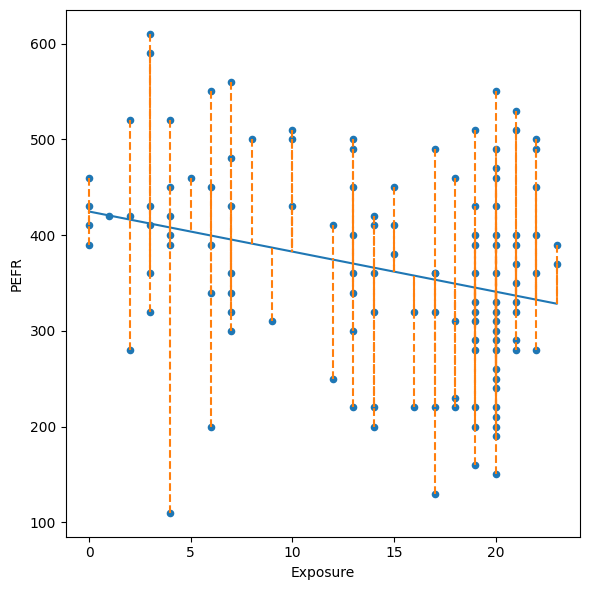

In [10]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(6, 6))  # Create a scatter plot of 'Exposure' vs 'PEFR' with a figure size of 4x4 inches
ax.plot(lung.Exposure, fitted)                                  # Plot the fitted regression line on the scatter plot

# Loop through each data point to plot vertical lines representing residuals (difference between actual and predicted values)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted):  
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')       # Plot a dashed line connecting the actual and predicted points for each observation

plt.tight_layout()  # Adjust layout to remove any excess white space around the plot
plt.show()          # Display the final plot

# Multiple linear regression

In [12]:
url2= ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/house_sales.csv')

house = pd.read_csv(url2, sep='\t')

subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']

house[subset].head()

,AdjSalePrice,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
1,300805.0,2400,9373,3.00,6,7
2,1076162.0,3764,20156,3.75,4,10
3,761805.0,2060,26036,1.75,4,8
4,442065.0,3200,8618,3.75,5,7
5,297065.0,1720,8620,1.75,4,7


In [13]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()                    # Create an instance of the LinearRegression model
house_lm.fit(house[predictors], house[outcome])  # Fit the linear regression model

print(f'Intercept: {house_lm.intercept_:.3f}\n')
print('Coefficients:\n')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -528724.348

Coefficients:

 SqFtTotLiving: 212.7079279709184
 SqFtLot: -0.014301274559294086
 Bathrooms: -18233.211748820704
 Bedrooms: -46574.19268657801
 BldgGrade: 108780.111342966


# Assessing the Model

In [15]:
fitted = house_lm.predict(house[predictors])                # Predict the outcome using the fitted linear regression model
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))  # Calculate the Root Mean Squared Error (RMSE) for model accuracy
r2 = r2_score(house[outcome], fitted)                       # Calculate the R-squared value to determine the model's goodness of fit

print(f'RMSE: {RMSE:.0f}')
print(f'r^2: {r2:.4f}')

RMSE: 259326
r^2: 0.5348


As statsmodels doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the pandas method assign for this.

In [17]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))  # Create an OLS (Ordinary Least Squares) model with the predictors and outcome
results = model.fit()                                              # Fit the OLS model to the data to find the best-fitting parameters
print(results.summary())                                           # Print the summary of the model

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     6222.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:38:21   Log-Likelihood:            -3.7576e+05
No. Observations:               27063   AIC:                         7.515e+05
Df Residuals:                   27057   BIC:                         7.516e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   212.7079      3.401     62.552

# Model Selection and Stepwise Regression

In [19]:
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


In [20]:
# Define the predictors (features) to be used in the model
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

# Convert categorical variables to dummy variables for regression and drop the first level to avoid multicollinearity
X = pd.get_dummies(house[predictors], drop_first=True, dtype=int)

# Ensure 'NewConstruction' is binary (1 if new construction, 0 otherwise)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

# Create an OLS (Ordinary Least Squares) model using the predictors and adding a constant for the intercept
house_full = sm.OLS(house[outcome], X.assign(const=1))

# Fit the OLS model to the data to estimate the coefficients
results = house_full.fit()

# Print a summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     3248.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:38:21   Log-Likelihood:            -3.7405e+05
No. Observations:               27063   AIC:                         7.481e+05
Df Residuals:                   27050   BIC:                         7.482e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

We can use the `stepwise_selection` method from the dmba package.

In [22]:
y = house[outcome]  # Define the target variable 'y' as the outcome column from the house DataFrame

# Function to train a linear regression model given a list of variables (predictors)
def train_model(variables):
    if len(variables) == 0:     # If no variables are provided, return None
        return None
    model = LinearRegression()  # Create a LinearRegression model instance
    model.fit(X[variables], y)  # Train the model on the given predictors from X and the target y
    return model                # Return the trained model

# Function to calculate the AIC score for a model given its trained instance and variables
def score_model(model, variables):
    if len(variables) == 0:  # If no variables are provided, calculate AIC using the mean of 'y'
        return AIC_score(y, [y.mean()] * len(y), model, df=1) # AIC for a simple model using mean prediction
    return AIC_score(y, model.predict(X[variables]), model)   # Calculate AIC using model predictions for given variables

# Perform stepwise selection to find the best model and its predictors
best_model, best_variables = stepwise_selection(X.columns,    # Start with all columns from X as potential predictors
                                                train_model,  # Use train_model function to train models
                                                score_model,  # Use score_model function to evaluate models
                                                verbose=True) # Display progress during selection

# Print out the intercept and coefficients of the best model found
print()
print(f'Intercept: {best_model.intercept_:.3f}')          # Print the intercept of the best model with 3 decimal precision
print('Coefficients:')                                    # Print the header for coefficients
for name, coef in zip(best_variables, best_model.coef_):  # Loop over the selected variables and their corresponding coefficients
    print(f' {name}: {coef}')                             # Print each variable name and its corresponding coefficient

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=772245.03, constant
Step: score=754910.45, add SqFtTotLiving
Step: score=752023.16, add BldgGrade
Step: score=749035.73, add YrBuilt
Step: score=748559.37, add Bedrooms
Step: score=748275.34, add Bathrooms
Step: score=748116.31, add PropertyType_Townhouse
Step: score=748113.49, add SqFtFinBasement
Step: score=748113.25, add PropertyType_Single Family
Step: score=748113.25, unchanged None

Intercept: 6227632.223
Coefficients:
 SqFtTotLiving: 186.50122142197543
 BldgGrade: 139179.22569572498
 YrBuilt: -3592.467561888604
 Bedrooms: -49807.17848564466
 Bathrooms: 44721.72109363838
 PropertyType_Townhouse: 92216.25324971136
 SqFtFinBasement: 9.0399110528233
 PropertyType_Single Family: 23328.685220410283


# Weighted regression

Weighted regression is used by statisticians for a variety of purposes; in particular, it is important for analysis of complex surveys. Data scientists may find weighted regression useful in two cases:

    • Inverse-variance weighting when different observations have been measured with different precision; the higher variance ones receiving lower weights.
    
    • Analysis of data where rows represent multiple cases; the weight variable encodes how many original observations each row represents.

We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

In [24]:
# Extract the year from the 'DocumentDate' column by splitting on '-' and take the first part, convert it to an integer
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]

# Alternative approach to extract the year using the apply method with a lambda function to split the date and convert to integer
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))

# Calculate the weight based on the difference between the extracted year and 2005
house['Weight'] = house.Year - 2005

house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,Year,Weight
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,7,1991,0,0,70000,229000,98002,False,2014,9
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,10,2005,0,0,203000,590000,98166,True,2006,1
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,8,1947,0,0,183000,275000,98166,False,2007,2
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,7,1966,0,0,104000,229000,98168,False,2008,3
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,7,1948,0,0,104000,205000,98168,False,2013,8


In [25]:
# Define the list of predictor variables (features)
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']

# Define the outcome variable (target)
outcome = 'AdjSalePrice'

# Create an instance of the LinearRegression model
house_wt = LinearRegression()

# Fit the linear model to the data, including weights ('Weight') for each sample
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)

# Combine model coefficients and intercepts into a single DataFrame for easy comparison
pd.concat([
    pd.DataFrame({
        'predictor': predictors,     # List of predictor variable names
        'house_lm': house_lm.coef_,  # Coefficients from the unweighted linear model
        'house_wt': house_wt.coef_,  # Coefficients from the weighted linear model
    }),
    pd.DataFrame({
        'predictor': ['intercept'],       # Label for the intercept row
        'house_lm': house_lm.intercept_,  # Intercept from the unweighted model
        'house_wt': house_wt.intercept_,  # Intercept from the weighted model
    })
])

,predictor,house_lm,house_wt
0,SqFtTotLiving,212.707928,229.945441
1,SqFtLot,-0.014301,-0.180740
2,Bathrooms,-18233.211749,-23335.485590
3,Bedrooms,-46574.192687,-54234.376222
4,BldgGrade,108780.111343,116037.062607
0,intercept,-528724.348047,-580378.014915


This output shows the coefficients from two different linear regression models (`house_lm` and `house_wt`), one without weighting and one with weighting. Let me explain each part of the output:

#### Columns Description:

`predictor`: This column lists the different features (independent variables) used in the model.

`house_lm`: These are the coefficients from the unweighted linear regression model (house_lm). This model fits a standard linear regression without applying any specific weights to the observations.

`house_wt`: These are the coefficients from the weighted linear regression model (house_wt). In this model, a weight is applied to each observation, and the weight is based on the Weight column, which gives more importance to certain observations.

#### Coefficient Interpretation:

`SqFtTotLiving`:

Unweighted (house_lm): A coefficient of 212.707928 means that, holding all other variables constant, each additional square foot of living space adds about 212.71 units to the sale price.
Weighted (house_wt): The coefficient is 229.945441, slightly higher, indicating that in the weighted model, the impact of living space is considered more significant.

`SqFtLot`:

The coefficient is negative in both models. This suggests that, after accounting for other features, larger lot sizes are correlated with a slight reduction in price. This could be because very large lots may indicate rural or less desirable properties.

`Bathrooms`:

Both models have negative coefficients (-18233.21 and -23335.49), which might indicate that additional bathrooms are not associated with higher sale prices in this dataset, perhaps due to the features of other properties.

`Bedrooms`:

Similarly, the negative coefficient for bedrooms (-46574.19 in house_lm and -54234.38 in house_wt) suggests that after accounting for other factors, adding additional bedrooms reduces the sale price. This may occur if more bedrooms lead to a smaller overall living space (e.g., bedrooms are smaller), or the market could favor fewer, larger bedrooms rather than more, smaller bedrooms.

`BldgGrade`:

Building grade is a positive influence in both models, as expected. Higher building grades (BldgGrade) are positively correlated with a higher sale price (108780.11 in house_lm and 116037.06 in house_wt). The weighted model values this feature slightly more.

`Intercept`:

The intercept represents the expected sale price when all predictors are 0. The intercept in the unweighted model (-528724.35) is negative, and so is the intercept in the weighted model (-580378.01). A negative intercept doesn’t make much practical sense in a real-world context for home prices, but it’s part of the linear estimation to fit the data. It’s mostly a baseline value from which the contributions of the features adjust the final predicted price.

#### Conclusion:

* Weighting has affected the coefficients, and in most cases, the weighted model assigns larger values, meaning recent data had a more significant impact.

* This comparison is useful for understanding the influence of weighting on your predictions, especially if the housing market trends have changed over time. Using weights can help capture these temporal trends better, potentially leading to more accurate predictions for current data.

## Residuals

In [31]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())

   abs_residual_lm  abs_residual_wt  Year
1    108151.621271     85838.687471  2014
2     28587.834970     61256.671364  2006
3    200687.364975    202679.266822  2007
4    169968.044985    165404.260990  2008
5     83200.899170     70989.994742  2013


#### Overall Insight:
*The weighted model generally performs better*, as evidenced by **lower residuals**, especially for more recent years. This indicates that giving more emphasis to recent data helps improve the prediction accuracy of housing prices, reflecting that housing market trends change over time, and recent transactions carry more relevant information for making current predictions.

(0.0, 300000.0)

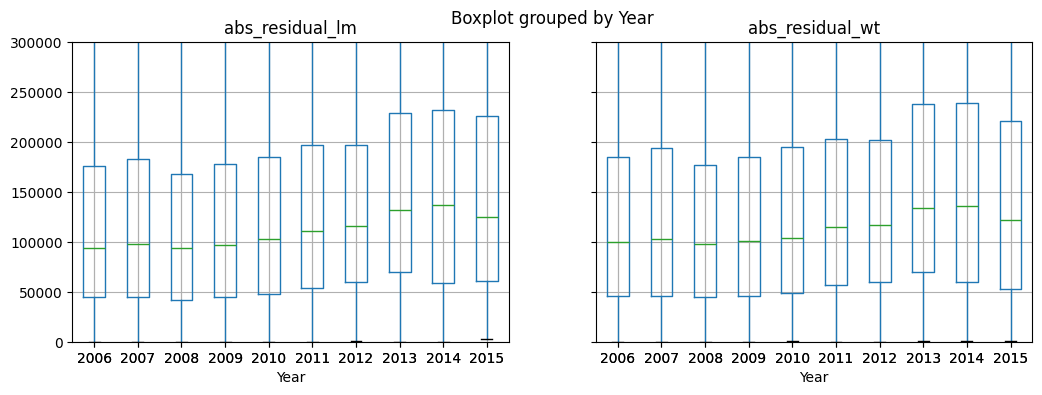

In [33]:
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(12, 4))
axes[0].set_ylim(0, 300000)

    1. Lower Residuals for the Weighted Model
    2. Performance Improvement in Recent Years
    3. Spread of Residuals
    4. Effectiveness of the Weighted Model

Overall, weighting recent observations is a more effective strategy for predicting housing prices, particularly in a dynamic and evolving market.

In [35]:
pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])

,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140301.192933,145687.634781
1,2007,146842.626813,151410.007129
2,2008,137931.963873,141508.965192
3,2009,140534.687895,144244.344756
4,2010,154180.099452,156602.990398
5,2011,160235.297008,162278.024163
6,2012,158657.754195,160944.278818
7,2013,196160.689911,198662.512253
8,2014,186182.380589,188076.467771
9,2015,174706.643226,171719.514055


The weighted model is more suitable if you are focusing on adapting to recent changes, while the unweighted model is more stable across the years. The trade-off between these two approaches depends on the specific goals of the analysis and how much importance you place on recent vs. past data.

In [37]:
# Another way
for year, group in residuals.groupby('Year'):
    print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

2006 140301.19293302295 145687.63478149625
2007 146842.62681264518 151410.00712856618
2008 137931.9638726512 141508.96519178562
2009 140534.68789458284 144244.34475645595
2010 154180.0994516696 156602.99039848533
2011 160235.29700763986 162278.02416268736
2012 158657.75419542068 160944.27881799501
2013 196160.6899106804 198662.51225255037
2014 186182.38058892704 188076.46777130754
2015 174706.64322578296 171719.51405532417


# Factor variables in regression
### Dummy Variables Representation

In [39]:
house['PropertyType'].head()

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object

In [40]:
unique_property_types = house['PropertyType'].unique()
print(unique_property_types)

['Multiplex' 'Single Family' 'Townhouse']


In [41]:
property_type_counts = house['PropertyType'].value_counts()
print(property_type_counts)

PropertyType
Single Family    23488
Townhouse         3316
Multiplex          259
Name: count, dtype: int64


### One Hot Encoding

In [43]:
pd.get_dummies(house['PropertyType']).head(6)

,Multiplex,Single Family,Townhouse
1,True,False,False
2,False,True,False
3,False,True,False
4,False,True,False
5,False,True,False
6,False,False,True


The keyword argument drop_first will return P – 1 columns. Use this to avoid
the problem of multicollinearity.

In [45]:
pd.get_dummies(house['PropertyType'], drop_first=True).head(6)

,Single Family,Townhouse
1,False,False
2,True,False
3,True,False
4,True,False
5,True,False
6,False,True


In [46]:
# Define a list of predictor variables including square footage, lot size, bathrooms, bedrooms, building grade, and property type
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade', 'PropertyType']

# Create dummy variables for categorical predictor 'PropertyType' and drop the first level to avoid multicollinearity
X = pd.get_dummies(house[predictors], drop_first=True)

# Create an instance of the LinearRegression model
house_lm_factor = LinearRegression()

# Fit the model using the predictors and the outcome variable from the house dataset
house_lm_factor.fit(X, house[outcome])    # outcome = 'AdjSalePrice'

# Print the intercept of the model
print(f'Intercept: {house_lm_factor.intercept_:.3f}')

# Print the coefficients of the model for each predictor
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):  # Iterate through the predictors and their corresponding coefficients
    print(f' {name}: {coef}')  # Print each predictor's name along with its coefficient

Intercept: -440890.853
Coefficients:
 SqFtTotLiving: 207.23954229359683
 SqFtLot: -0.02313895845995617
 Bathrooms: -14996.674366959409
 Bedrooms: -49570.07618833289
 BldgGrade: 112183.58059922782
 PropertyType_Single Family: -98192.29974717998
 PropertyType_Townhouse: -118938.43483445166


## Factor Variables with Many Levels

In [48]:
pd.DataFrame(house['ZipCode'].value_counts()).transpose()

ZipCode,-1,98038,98103,98042,98115,98117,98052,98034,98033,98059,...,98354,98050,98057,98288,98224,98068,98113,9800,89118,98043
count,4374,788,671,641,620,619,614,575,517,513,...,9,7,4,4,3,1,1,1,1,1


ZipCode is an important variable, since it is a proxy for the effect of location on the value of a house. We can consolidate a zip code using the first two or three digits, corresponding to a submetropolitan geographic region. For King County, almost all of the sales occur in 980xx or 981xx, so this doesn’t help.

An alternative approach is to group the zip codes according to another variable, such as sale price. Even better is to form zip code groups using the residuals from an initial model. The following code consolidates the 80 zip codes into five groups based on the median of the residual from the house_lm regression:

In [50]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms',               # List of features used as predictors for the model
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'                                             # Outcome variable that we are trying to predict

house_lm = LinearRegression()                                        # Initialize a Linear Regression model
house_lm.fit(house[predictors], house[outcome])                      # Fit the model using the predictors and outcome variable

# Create a DataFrame to store ZipCode and the residuals of the predicted values
zip_residuals = pd.DataFrame({
    'ZipCode': house['ZipCode'],                                      # Column storing ZipCodes of each house
    'residual': house[outcome] - house_lm.predict(house[predictors]), # Calculate the residuals (difference between actual and predicted sale price)
})

# Group residuals by ZipCode, calculate count, and median residual for each group
zip_groups = pd.DataFrame([
    {
        'ZipCode': zipCode,                                          # Store the ZipCode for each group
        'count': len(x),                                             # Count of the number of houses in each ZipCode group
        'median_residual': x.residual.median()                       # Median of residuals for each ZipCode group
    } 
    for zipCode, x in zip_residuals.groupby('ZipCode')               # Iterate over each ZipCode group
]).sort_values('median_residual')                                    # Sort ZipCode groups based on median residual values

# Calculate cumulative count and assign ZipGroup labels
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])             # Create a cumulative sum of house counts in each ZipCode group
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False) # Divide the ZipCodes into 5 quantile groups based 
                                                                     # on cumulative count

zip_groups.head()                                                    # Display the first few rows of the DataFrame
print(zip_groups.ZipGroup.value_counts().sort_index())               # Count and display the number of ZipCodes in each ZipGroup

ZipGroup
0    17
1    16
2    17
3    16
4    17
Name: count, dtype: int64


The last code performs a residual analysis of a linear regression model, grouping residuals by ZipCode and analyzing how these residuals vary across different areas. Here's a summary of what the code does:

1. Define Predictors and Fit a Linear Model;
2. Calculate Residuals for Each House;
3. Group by ZipCode and Analyze Residuals;
4. Sort by Median Residual and Assign ZipGroup Labels;
5. Summarize ZipGroup Assignments;
6. Finally, it prints the count of ZipCodes in each ZipGroup.

#### Purpose of the Code
The code is trying to understand spatial variability in residuals by analyzing the residuals grouped by ZipCode. This helps:
Identify bias in the model: If certain ZipCodes have higher or lower median residuals, it might indicate that the model systematically underpredicts or overpredicts in those areas.
Cluster ZipCodes into groups: By dividing them into quantiles, the code essentially clusters ZipCodes based on their residual patterns.
#### Use Case
This kind of analysis can be used to improve model performance by understanding whether different geographical areas (ZipCodes) are not well predicted by the current features.
It could also help in feature engineering by adding more spatial-specific features to reduce systematic prediction errors for certain locations.

In [52]:
# Select 'ZipCode' and 'ZipGroup' columns from zip_groups and set 'ZipCode' as index
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')  

# Join the 'house' DataFrame with 'to_join' using 'ZipCode' as the key
house = house.join(to_join, on='ZipCode')  

# Convert the 'ZipGroup' column to a categorical data type
house['ZipGroup'] = house['ZipGroup'].astype('category')  

In [53]:
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,Year,Weight,ZipGroup
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,1991,0,0,70000,229000,98002,False,2014,9,1
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,2005,0,0,203000,590000,98166,True,2006,1,2
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1947,0,0,183000,275000,98166,False,2007,2,2
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,1966,0,0,104000,229000,98168,False,2008,3,2
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1948,0,0,104000,205000,98168,False,2013,8,2


# Interpreting the Regression Equation
### Correlated predictors

In multiple regression, the predictor variables are often correlated with each other.

In [56]:
print(f'Intercept: {best_model.intercept_:.3f}')  # Print the intercept of the best model with 3 decimal places
print('Coefficients:')                            # Print a label for the coefficients

for name, coef in zip(best_variables, best_model.coef_):  # Iterate over each variable and its corresponding coefficient
    print(f' {name}: {coef}')                             # Print the variable name and its coefficient value

Intercept: 6227632.223
Coefficients:
 SqFtTotLiving: 186.50122142197543
 BldgGrade: 139179.22569572498
 YrBuilt: -3592.467561888604
 Bedrooms: -49807.17848564466
 Bathrooms: 44721.72109363838
 PropertyType_Townhouse: 92216.25324971136
 SqFtFinBasement: 9.0399110528233
 PropertyType_Single Family: 23328.685220410283


The coefficient for Bedrooms is negative! This implies that adding a bedroom to a
house will reduce its value. How can this be? This is because the predictor variables
are correlated: larger houses tend to have more bedrooms, and it is the size that drives
house value, not the number of bedrooms. Consider two homes of the exact same
size: it is reasonable to expect that a home with more but smaller bedrooms would be
considered less desirable.

Having correlated predictors can make it difficult to interpret the sign and value ofregression coefficients (and can inflate the standard error of the estimates). The variables for bedrooms, house size, and number of bathrooms are all correlated.

In [58]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']  # List of predictor variables
outcome = 'AdjSalePrice'                                           # Define the outcome variable

X = pd.get_dummies(house[predictors], drop_first=True)  # Convert categorical variables to dummy variables and drop the first level

reduced_lm = LinearRegression()    # Create an instance of the LinearRegression model
reduced_lm.fit(X, house[outcome])  # Fit the model using predictors X and the outcome variable

print(f'Intercept: {reduced_lm.intercept_:.3f}')     # Print the model's intercept value
print('Coefficients:')                               # Print a label for the coefficients
for name, coef in zip(X.columns, reduced_lm.coef_):  # Iterate over each predictor and its corresponding coefficient
    print(f' {name}: {coef}')                        # Print the predictor name and its coefficient value

Intercept: 4834679.732
Coefficients:
 Bedrooms: 27656.8165542268
 BldgGrade: 245709.38992928946
 YrBuilt: -3160.629201101372
 PropertyType_Single Family: -17603.91511703282
 PropertyType_Townhouse: -47477.2366641131


The update function can be used to add or remove variables from a model. Now the
coefficient for bedrooms is positive—in line with what we would expect (though it is
really acting as a proxy for house size, now that those variables have been removed).

# Confounding Variables

With correlated variables, the problem is one of commission: including different variables that have a similar predictive relationship with the response. With confounding
variables, the problem is one of omission: an important variable is not included in the
regression equation. Naive interpretation of the equation coefficients can lead to invalid conclusions

In [62]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',  # List of continuous predictors
              'BldgGrade', 'PropertyType', 'ZipGroup']              # Additional categorical predictors

outcome = 'AdjSalePrice'  # Outcome variable to predict

X = pd.get_dummies(house[predictors], drop_first=True)  # Convert categorical variables to dummy variables and 
                                                        # drop the first level to avoid multicollinearity

confounding_lm = LinearRegression()    # Create an instance of the Linear Regression model
confounding_lm.fit(X, house[outcome])  # Fit the model using the predictors and outcome variable

print(f'Intercept: {confounding_lm.intercept_:.3f}')     # Print the intercept of the model
print('Coefficients:')                                   # Print the header for coefficients
for name, coef in zip(X.columns, confounding_lm.coef_):  # Iterate through predictor names and corresponding coefficients
    print(f' {name}: {coef}')                            # Print each predictor and its corresponding coefficient value

Intercept: -677704.741
Coefficients:
 SqFtTotLiving: 193.65643195950722
 SqFtLot: 0.3545579266488659
 Bathrooms: 8601.372268904792
 Bedrooms: -39162.110675291246
 BldgGrade: 105173.07791335067
 PropertyType_Single Family: 2045.5643325584265
 PropertyType_Townhouse: -21419.37384501969
 ZipGroup_1: 58157.50729246873
 ZipGroup_2: 101551.16020696687
 ZipGroup_3: 170540.65609438907
 ZipGroup_4: 326770.93935705494


The original regression model does not contain a variable to represent location—a very important predictor of house price.

ZipGroup is clearly an important variable: a home in the most expensive zip codegroup is estimated to have a higher sales price by almost \\$340,000. The coefficients ofSqFtLot and Bathrooms are now positive, and adding a bathroom increases the saleprice by $8,601.

The coefficient for Bedrooms is still negative. While this is unintuitive, this is a wellknown phenomenon in real estate. For homes of the same livable area and number of bathrooms, having more and therefore smaller bedrooms is associated with less valuable homes.

# Interactions and Main Effects

In [65]:
# Create an Ordinary Least Squares (OLS) regression model
model = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving*ZipGroup + SqFtLot + ' +
                'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)

results = model.fit()     # Fit the model using the specified formula and the 'house' DataFrame
results.summary()         # Print the summary of the regression results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     3544.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:38:23   Log-Likelihood:            -3.7141e+05
No. Observations:               27063   AIC:                         7.429e+05
Df Residuals:                   27047   BIC:                         7.430e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -4.992e+05   2.02e+04    -24.658      0.000   -5.39e+05   -4.59e+05
ZipGroup[T.1]                 -4.036e+04   1.14e+04     -3.540      0.000   -6.27e+04    -1.8e+04
ZipGroup[T.2]                  5.374e+04   1.26e+04      4.274      0.000    2.91e+04    7.84e+04
ZipGroup[T.3]                 -9703.7512   1.17e+04     -0.828      0.408   -3.27e+04    1.33e+04
ZipGroup[T.4]                 -1.671e+05   1.15e+04    -14.594      0.000    -1.9e+05   -1.45e+05
PropertyType[T.Single Family]  3645.8752    1.4e+04      0.260      0.795   -2.39e+04    3.12e+04
PropertyType[T.Townhouse]     -2.338e+04   1.49e+04     -1.569      0.117   -5.26e+04    5836.072
SqFtTotLiving                   102.7756      4.841     21.231      0.000      93.287     112.264
SqFtTotLiving:ZipGroup[T.1]      50.8178      4.794     10.600      0.000      41.421      60.214
SqFtTotLiving:ZipGroup[T.2]      15.9481      5.754      2.772      0.006       4.670      27.226
SqFtTotLiving:ZipGroup[T.3]      84.6914      5.228     16.200      0.000      74.445      94.938
SqFtTotLiving:ZipGroup[T.4]     231.1292      4.934     46.846      0.000     221.459     240.800
SqFtLot                           0.5546      0.050     11.182      0.000       0.457       0.652
Bathrooms                       459.0787   2973.350      0.154      0.877   -5368.841    6286.999
Bedrooms                      -3.918e+04   2039.268    -19.214      0.000   -4.32e+04   -3.52e+04
BldgGrade                      1.088e+05   1931.783     56.334      0.000    1.05e+05    1.13e+05
==============================================================================
Omnibus:                    34383.560   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         27806264.203
Skew:                           6.416   Prob(JB):                         0.00
Kurtosis:                     159.507   Cond. No.                     6.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
# Extract parameters and sort them in descending order
coefficients = results.params.sort_values(ascending=False)

# Print the coefficients
print(coefficients)

BldgGrade                        108825.388840
ZipGroup[T.2]                     53742.278099
PropertyType[T.Single Family]      3645.875244
Bathrooms                           459.078682
SqFtTotLiving:ZipGroup[T.4]         231.129206
SqFtTotLiving                       102.775553
SqFtTotLiving:ZipGroup[T.3]          84.691360
SqFtTotLiving:ZipGroup[T.1]          50.817779
SqFtTotLiving:ZipGroup[T.2]          15.948114
SqFtLot                               0.554622
ZipGroup[T.3]                     -9703.751197
PropertyType[T.Townhouse]        -23380.082299
Bedrooms                         -39181.624347
ZipGroup[T.1]                    -40357.684544
ZipGroup[T.4]                   -167115.833112
Intercept                       -499159.969711
dtype: float64
